In [1]:
from known_boundary.GP import optimise,optimise_warp,optimise_warp_no_boundary
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_EI_acquisition_opt,Warped_TEI2_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

function_information = []



temp={}
#temp['name']='Beale' 
temp['function'] = Rosenbrock(dim=5,negate=False)
temp['fstar'] = 0.
temp['min']=True 
function_information.append(temp)




for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    iter_num = 60
    N = 1

    fstar = information['fstar']
    fun = Trans_function(fun,fstar,min=True)
    
    
    # ################################################### GP+EI ###########################################
    # BO_EI = []

    # for exp in range(N):
        
    #     print(exp)
        
    #     seed = exp

    #     X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    #     Y_BO = torch.tensor(
    #         [fun(x) for x in X_BO], dtype=dtype, device=device
    #     ).reshape(-1,1)

    #     best_record = [Y_BO.min().item()]
    #     np.random.seed(1234)

    #     for i in range(iter_num):
            
    #             train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
    #             train_X = normalize(X_BO, bounds)
                
    #             minimal = train_Y.min().item()
                
    #             train_Y = train_Y.numpy()
    #             train_X = train_X.numpy()
                
    #             # train the GP
    #             res = optimise(train_X,train_Y)
    #             kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
    #             m = GPy.models.GPRegression(train_X, train_Y,kernel)
    #             m.Gaussian_noise.variance.fix(10**(-5))

    #             standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
    #             X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
    #             Y_next = fun(X_next).reshape(-1,1)

    #             # Append data
    #             X_BO = torch.cat((X_BO, X_next), dim=0)
    #             Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
    #             best_record.append(Y_BO.min().item())
                
    #     best_record = np.array(best_record)+fstar 
    #     BO_EI.append(best_record)

    
    ##################################################### log GP+logTEI ##################################################
    Warped_BO_logTEI = []

    for exp in range(N):

        seed = exp
        
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        np.random.seed(1234)
   
        for i in range(iter_num):
            
                print(i)
            
                train_Y  = (Y_BO ) / Y_BO.std() #Y_BO.numpy()
                train_Y = train_Y.numpy()
                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
                
                # train the GP
                res = optimise_warp(train_X, train_Y)
                lengthscale = np.sqrt(res[0])
                variance = res[1]
                c = res[2]
                
                print('lengthscale is: ',lengthscale)
                print('variance is: ',variance)
                print('c is: ',c)
                
                
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(10**(-5))
                
                standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
                best_record.append(Y_BO.min().item())
                print('regret:', best_record[-1])
                
        best_record = np.array(best_record)+fstar         
        Warped_BO_logTEI.append(best_record)

    

    

            

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0
0
lengthscale is:  0.3992639844435823
variance is:  1.4204713767749553
c is:  0.01
regret: 10187.019429406684
1
lengthscale is:  0.42914782488716935
variance is:  1.5188696823118661
c is:  0.01
regret: 10187.019429406684
2
lengthscale is:  0.44591100422753954
variance is:  1.7410660907311686
c is:  1e-06
regret: 8890.797725080722
3
lengthscale is:  0.47427065395934126
variance is:  1.9027145294892491
c is:  1e-06
regret: 8890.797725080722
4
lengthscale is:  0.43237060024200047
variance is:  1.6985758933156008
c is:  0.00417891028113947
regret: 8890.797725080722
5
lengthscale is:  0.4395069392911781
variance is:  1.8493646501590049
c is:  0.002211877794479802
regret: 8144.1348606373895
6
lengthscale is:  0.4297285947051343
variance is:  1.9615158131027557
c is:  0.0009553378908291433
regret: 8144.1348606373895
7
lengthscale is:  0.40153148952967216
variance is:  1.906673540709319
c is:  0.01
regret: 8144.1348606373895
8
lengthscale is:  0.3896441125979208
variance is:  1.8394451113808

In [4]:
import  os
import numpy as np
import matplotlib.pyplot as plt

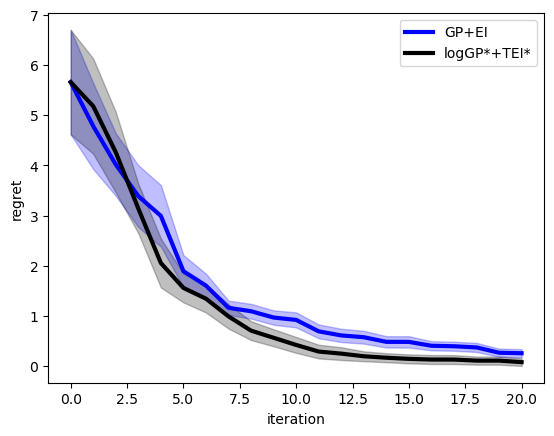

In [5]:
N = 20
fstar =  0.397887
total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_logTEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+TEI*',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()

Text(0.5, 1.0, 'Ackley 10D')

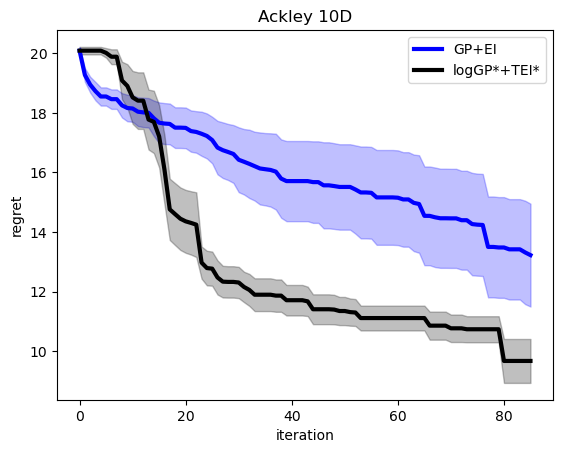

In [4]:
N = 10
fstar =  0.
total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_logTEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+TEI*',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Ackley 10D')